[View in Colaboratory](https://colab.research.google.com/github/ozanpekmezci/capstone/blob/master/multi_digit_recognition_svhn.ipynb)

# Multi Digit Number Recognition with SVHN

This notebook implements multi digit number recognition using SVHN dataset that will be used to recognize house numbers at the streets. It can be considered as second version of the previous multi digit recognition which uses MNIST database. Keras and Tensorflow libraries are used to build the recognizer.
This recognizer extracts digit from the image using Convolutional Neural Network Classifier.

In [0]:
# Module Imports
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

from six.moves import cPickle as pickle
from six.moves import range


import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Setting the random seed so that the results are reproducible. 
random.seed(42)


## Load Dataset

In [34]:
pickle_file = 'SVHN_multi_crop.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (27401, 64, 64) (27401, 5)
Validation set (6000, 64, 64) (6000, 5)
Test set (13068, 64, 64) (13068, 5)


Label for image: [ 2  2 10 10 10]


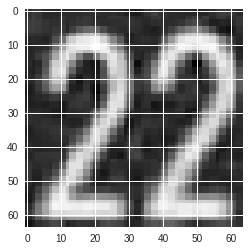

In [35]:
plt.figure()
plt.imshow(train_dataset[50], cmap='gray')

print("Label for image: {}".format(train_labels[50]))

## Convert Labels
This function converts each digit label to one-hot array.

In [0]:
# Converting labels to One-hot representations of shape (set_size, digits, classes)
possible_classes = 11

def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        # Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [0]:
train_labels = convert_labels(train_labels)
test_labels = convert_labels(test_labels)
valid_labels = convert_labels(valid_labels)

In [38]:
# Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(27401, 11)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [0]:
def prep_data_keras(img_data):
    
    # Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data), 64, 64, 1)
    
    # Converting everything to floats
    img_data = img_data.astype('float32')
    
    # Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data


In [0]:
train_images = prep_data_keras(train_dataset)
test_images = prep_data_keras(test_dataset)
valid_images = prep_data_keras(valid_dataset)

In [41]:
np.shape(train_images)

(27401, 64, 64, 1)

In [42]:
np.shape(test_images)

(13068, 64, 64, 1)

In [0]:
# Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

## Build Model
Build Deep Learning model to process data.

In [57]:
# Building the model

batch_size = 32
nb_classes = 11
nb_epoch = 48

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1],border_mode='same')(inputs)
cov = Activation('relu')(cov)
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1])(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.25)(cov)
cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(128, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model = Model(input=inputs,output=[c0,c1,c2,c3,c4])

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,nb_epoch=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 27401 samples, validate on 6000 samples
Epoch 1/48
16512/27401 [=================>............] - ETA: 15s - loss: 6.3430 - dense_26_loss: 2.1065 - dense_27_loss: 2.4545 - dense_28_loss: 1.4024 - dense_29_loss: 0.3289 - dense_30_loss: 0.0507 - dense_26_acc: 0.2436 - dense_27_acc: 0.1208 - dense_28_acc: 0.6903 - dense_29_acc: 0.9564 - dense_30_acc: 0.9980

27401/27401 [==============================] - 41s 2ms/step - loss: 6.1692 - dense_26_loss: 2.0662 - dense_27_loss: 2.4125 - dense_28_loss: 1.3408 - dense_29_loss: 0.3145 - dense_30_loss: 0.0352 - dense_26_acc: 0.2624 - dense_27_acc: 0.1395 - dense_28_acc: 0.6952 - dense_29_acc: 0.9564 - dense_30_acc: 0.9987 - val_loss: 5.5608 - val_dense_26_loss: 1.8791 - val_dense_27_loss: 2.2374 - val_dense_28_loss: 1.1723 - val_dense_29_loss: 0.2671 - val_dense_30_loss: 0.0048 - val_dense_26_acc: 0.3458 - val_dense_27_acc: 0.2177 - val_dense_28_acc: 0.6903 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 2/48
 2976/27401 [==>...........................] - ETA: 31s - loss: 5.5975 - dense_26_loss: 1.9242 - dense_27_loss: 2.2371 - dense_28_loss: 1.1463 - dense_29_loss: 0.2757 - dense_30_loss: 0.0142 - dense_26_acc: 0.3266 - dense_27_acc: 0.2218 - dense_28_acc: 0.7134 - dense_29_acc: 0.9570 - dense_30_acc: 0.9993

23552/27401 [========================>.....] - ETA: 4s - loss: 5.4316 - dense_26_loss: 1.8409 - dense_27_loss: 2.1749 - dense_28_loss: 1.1420 - dense_29_loss: 0.2638 - dense_30_loss: 0.0100 - dense_26_acc: 0.3653 - dense_27_acc: 0.2483 - dense_28_acc: 0.6976 - dense_29_acc: 0.9565 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 5.4003 - dense_26_loss: 1.8317 - dense_27_loss: 2.1649 - dense_28_loss: 1.1351 - dense_29_loss: 0.2590 - dense_30_loss: 0.0096 - dense_26_acc: 0.3683 - dense_27_acc: 0.2517 - dense_28_acc: 0.6986 - dense_29_acc: 0.9572 - dense_30_acc: 0.9997 - val_loss: 5.0196 - val_dense_26_loss: 1.6924 - val_dense_27_loss: 2.0229 - val_dense_28_loss: 1.0634 - val_dense_29_loss: 0.2356 - val_dense_30_loss: 0.0052 - val_dense_26_acc: 0.4267 - val_dense_27_acc: 0.3192 - val_dense_28_acc: 0.6930 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 3/48
 5376/27401 [====>.........................] - ETA: 27s - loss: 5.1514 - dense_26_loss: 1.7622 - dense_27_loss: 2.0809 - dense_28_loss: 1.0774 - dense_29_loss: 0.2229 - dense_30_loss: 0.0082 - dense_26_acc: 0.3975 - dense_27_acc: 0.2930 - dense_28_acc: 0.7024 - dense_29_acc: 0.9606 - dense_30_acc: 1.0000

26144/27401 [===========================>..] - ETA: 1s - loss: 5.0543 - dense_26_loss: 1.7237 - dense_27_loss: 2.0323 - dense_28_loss: 1.0518 - dense_29_loss: 0.2373 - dense_30_loss: 0.0092 - dense_26_acc: 0.4066 - dense_27_acc: 0.3005 - dense_28_acc: 0.7023 - dense_29_acc: 0.9576 - dense_30_acc: 0.9998

27401/27401 [==============================] - 36s 1ms/step - loss: 5.0476 - dense_26_loss: 1.7213 - dense_27_loss: 2.0309 - dense_28_loss: 1.0481 - dense_29_loss: 0.2379 - dense_30_loss: 0.0095 - dense_26_acc: 0.4088 - dense_27_acc: 0.3011 - dense_28_acc: 0.7028 - dense_29_acc: 0.9572 - dense_30_acc: 0.9997 - val_loss: 4.5492 - val_dense_26_loss: 1.5252 - val_dense_27_loss: 1.8396 - val_dense_28_loss: 0.9617 - val_dense_29_loss: 0.2166 - val_dense_30_loss: 0.0060 - val_dense_26_acc: 0.5055 - val_dense_27_acc: 0.4100 - val_dense_28_acc: 0.7007 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 4/48
 6208/27401 [=====>........................] - ETA: 26s - loss: 4.7194 - dense_26_loss: 1.5852 - dense_27_loss: 1.9293 - dense_28_loss: 0.9715 - dense_29_loss: 0.2220 - dense_30_loss: 0.0115 - dense_26_acc: 0.4646 - dense_27_acc: 0.3439 - dense_28_acc: 0.7101 - dense_29_acc: 0.9573 - dense_30_acc: 0.9992

26528/27401 [============================>.] - ETA: 1s - loss: 4.5287 - dense_26_loss: 1.5144 - dense_27_loss: 1.8598 - dense_28_loss: 0.9351 - dense_29_loss: 0.2125 - dense_30_loss: 0.0070 - dense_26_acc: 0.4887 - dense_27_acc: 0.3638 - dense_28_acc: 0.7158 - dense_29_acc: 0.9568 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 4.5228 - dense_26_loss: 1.5123 - dense_27_loss: 1.8581 - dense_28_loss: 0.9343 - dense_29_loss: 0.2113 - dense_30_loss: 0.0068 - dense_26_acc: 0.4899 - dense_27_acc: 0.3639 - dense_28_acc: 0.7156 - dense_29_acc: 0.9572 - dense_30_acc: 0.9997 - val_loss: 3.9066 - val_dense_26_loss: 1.2536 - val_dense_27_loss: 1.6124 - val_dense_28_loss: 0.8418 - val_dense_29_loss: 0.1921 - val_dense_30_loss: 0.0067 - val_dense_26_acc: 0.5990 - val_dense_27_acc: 0.4933 - val_dense_28_acc: 0.7380 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 5/48
 6336/27401 [=====>........................] - ETA: 26s - loss: 4.1332 - dense_26_loss: 1.3737 - dense_27_loss: 1.7257 - dense_28_loss: 0.8477 - dense_29_loss: 0.1785 - dense_30_loss: 0.0076 - dense_26_acc: 0.5286 - dense_27_acc: 0.4140 - dense_28_acc: 0.7328 - dense_29_acc: 0.9586 - dense_30_acc: 0.9995

25472/27401 [==========================>...] - ETA: 2s - loss: 4.1059 - dense_26_loss: 1.3432 - dense_27_loss: 1.7002 - dense_28_loss: 0.8617 - dense_29_loss: 0.1943 - dense_30_loss: 0.0064 - dense_26_acc: 0.5405 - dense_27_acc: 0.4204 - dense_28_acc: 0.7285 - dense_29_acc: 0.9570 - dense_30_acc: 0.9997

27401/27401 [==============================] - 38s 1ms/step - loss: 4.0958 - dense_26_loss: 1.3411 - dense_27_loss: 1.6955 - dense_28_loss: 0.8594 - dense_29_loss: 0.1936 - dense_30_loss: 0.0062 - dense_26_acc: 0.5417 - dense_27_acc: 0.4209 - dense_28_acc: 0.7290 - dense_29_acc: 0.9572 - dense_30_acc: 0.9997 - val_loss: 3.5584 - val_dense_26_loss: 1.1077 - val_dense_27_loss: 1.4638 - val_dense_28_loss: 0.7930 - val_dense_29_loss: 0.1878 - val_dense_30_loss: 0.0061 - val_dense_26_acc: 0.6387 - val_dense_27_acc: 0.5343 - val_dense_28_acc: 0.7613 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 6/48
 5408/27401 [====>.........................] - ETA: 29s - loss: 3.8895 - dense_26_loss: 1.2468 - dense_27_loss: 1.6261 - dense_28_loss: 0.8194 - dense_29_loss: 0.1925 - dense_30_loss: 0.0046 - dense_26_acc: 0.5819 - dense_27_acc: 0.4373 - dense_28_acc: 0.7393 - dense_29_acc: 0.9551 - dense_30_acc: 0.9998

23680/27401 [========================>.....] - ETA: 4s - loss: 3.9049 - dense_26_loss: 1.2613 - dense_27_loss: 1.6150 - dense_28_loss: 0.8332 - dense_29_loss: 0.1896 - dense_30_loss: 0.0058 - dense_26_acc: 0.5739 - dense_27_acc: 0.4439 - dense_28_acc: 0.7363 - dense_29_acc: 0.9568 - dense_30_acc: 0.9997

27401/27401 [==============================] - 39s 1ms/step - loss: 3.8971 - dense_26_loss: 1.2591 - dense_27_loss: 1.6127 - dense_28_loss: 0.8314 - dense_29_loss: 0.1883 - dense_30_loss: 0.0057 - dense_26_acc: 0.5747 - dense_27_acc: 0.4448 - dense_28_acc: 0.7371 - dense_29_acc: 0.9573 - dense_30_acc: 0.9997 - val_loss: 3.3753 - val_dense_26_loss: 1.0261 - val_dense_27_loss: 1.3854 - val_dense_28_loss: 0.7742 - val_dense_29_loss: 0.1840 - val_dense_30_loss: 0.0056 - val_dense_26_acc: 0.6718 - val_dense_27_acc: 0.5528 - val_dense_28_acc: 0.7597 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 7/48
 4864/27401 [====>.........................] - ETA: 30s - loss: 3.7706 - dense_26_loss: 1.2115 - dense_27_loss: 1.5684 - dense_28_loss: 0.8034 - dense_29_loss: 0.1794 - dense_30_loss: 0.0079 - dense_26_acc: 0.5917 - dense_27_acc: 0.4607 - dense_28_acc: 0.7407 - dense_29_acc: 0.9566 - dense_30_acc: 0.9996

22720/27401 [=======================>......] - ETA: 6s - loss: 3.7706 - dense_26_loss: 1.2160 - dense_27_loss: 1.5550 - dense_28_loss: 0.8106 - dense_29_loss: 0.1836 - dense_30_loss: 0.0053 - dense_26_acc: 0.5871 - dense_27_acc: 0.4678 - dense_28_acc: 0.7389 - dense_29_acc: 0.9571 - dense_30_acc: 0.9997

27401/27401 [==============================] - 38s 1ms/step - loss: 3.7547 - dense_26_loss: 1.2118 - dense_27_loss: 1.5504 - dense_28_loss: 0.8051 - dense_29_loss: 0.1821 - dense_30_loss: 0.0052 - dense_26_acc: 0.5882 - dense_27_acc: 0.4692 - dense_28_acc: 0.7404 - dense_29_acc: 0.9574 - dense_30_acc: 0.9997 - val_loss: 3.2678 - val_dense_26_loss: 1.0030 - val_dense_27_loss: 1.3379 - val_dense_28_loss: 0.7487 - val_dense_29_loss: 0.1724 - val_dense_30_loss: 0.0057 - val_dense_26_acc: 0.6745 - val_dense_27_acc: 0.5717 - val_dense_28_acc: 0.7738 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 8/48
 4608/27401 [====>.........................] - ETA: 30s - loss: 3.6650 - dense_26_loss: 1.1887 - dense_27_loss: 1.5026 - dense_28_loss: 0.7869 - dense_29_loss: 0.1809 - dense_30_loss: 0.0058 - dense_26_acc: 0.5931 - dense_27_acc: 0.4874 - dense_28_acc: 0.7372 - dense_29_acc: 0.9542 - dense_30_acc: 0.9996

23744/27401 [========================>.....] - ETA: 4s - loss: 3.6306 - dense_26_loss: 1.1599 - dense_27_loss: 1.5006 - dense_28_loss: 0.7875 - dense_29_loss: 0.1776 - dense_30_loss: 0.0049 - dense_26_acc: 0.6030 - dense_27_acc: 0.4848 - dense_28_acc: 0.7440 - dense_29_acc: 0.9570 - dense_30_acc: 0.9997

27401/27401 [==============================] - 38s 1ms/step - loss: 3.6242 - dense_26_loss: 1.1597 - dense_27_loss: 1.4987 - dense_28_loss: 0.7841 - dense_29_loss: 0.1772 - dense_30_loss: 0.0045 - dense_26_acc: 0.6048 - dense_27_acc: 0.4856 - dense_28_acc: 0.7456 - dense_29_acc: 0.9575 - dense_30_acc: 0.9997 - val_loss: 3.1388 - val_dense_26_loss: 0.9532 - val_dense_27_loss: 1.2807 - val_dense_28_loss: 0.7282 - val_dense_29_loss: 0.1710 - val_dense_30_loss: 0.0056 - val_dense_26_acc: 0.7032 - val_dense_27_acc: 0.5878 - val_dense_28_acc: 0.7742 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 9/48
 5088/27401 [====>.........................] - ETA: 29s - loss: 3.5136 - dense_26_loss: 1.1114 - dense_27_loss: 1.4655 - dense_28_loss: 0.7546 - dense_29_loss: 0.1790 - dense_30_loss: 0.0030 - dense_26_acc: 0.6199 - dense_27_acc: 0.5002 - dense_28_acc: 0.7518 - dense_29_acc: 0.9550 - dense_30_acc: 0.9998

25280/27401 [==========================>...] - ETA: 2s - loss: 3.5147 - dense_26_loss: 1.1235 - dense_27_loss: 1.4504 - dense_28_loss: 0.7632 - dense_29_loss: 0.1729 - dense_30_loss: 0.0047 - dense_26_acc: 0.6162 - dense_27_acc: 0.5005 - dense_28_acc: 0.7517 - dense_29_acc: 0.9576 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 3.5229 - dense_26_loss: 1.1273 - dense_27_loss: 1.4546 - dense_28_loss: 0.7649 - dense_29_loss: 0.1718 - dense_30_loss: 0.0044 - dense_26_acc: 0.6152 - dense_27_acc: 0.4998 - dense_28_acc: 0.7518 - dense_29_acc: 0.9580 - dense_30_acc: 0.9997 - val_loss: 3.0385 - val_dense_26_loss: 0.9134 - val_dense_27_loss: 1.2440 - val_dense_28_loss: 0.7064 - val_dense_29_loss: 0.1693 - val_dense_30_loss: 0.0055 - val_dense_26_acc: 0.7093 - val_dense_27_acc: 0.6083 - val_dense_28_acc: 0.7873 - val_dense_29_acc: 0.9552 - val_dense_30_acc: 0.9997
Epoch 10/48
 5792/27401 [=====>........................] - ETA: 28s - loss: 3.4158 - dense_26_loss: 1.0991 - dense_27_loss: 1.3865 - dense_28_loss: 0.7497 - dense_29_loss: 0.1730 - dense_30_loss: 0.0075 - dense_26_acc: 0.6167 - dense_27_acc: 0.5261 - dense_28_acc: 0.7512 - dense_29_acc: 0.9582 - dense_30_acc: 0.9995

24832/27401 [==========================>...] - ETA: 3s - loss: 3.4327 - dense_26_loss: 1.0966 - dense_27_loss: 1.4098 - dense_28_loss: 0.7519 - dense_29_loss: 0.1702 - dense_30_loss: 0.0042 - dense_26_acc: 0.6231 - dense_27_acc: 0.5152 - dense_28_acc: 0.7527 - dense_29_acc: 0.9585 - dense_30_acc: 0.9997

27401/27401 [==============================] - 40s 1ms/step - loss: 3.4296 - dense_26_loss: 1.0904 - dense_27_loss: 1.4113 - dense_28_loss: 0.7532 - dense_29_loss: 0.1708 - dense_30_loss: 0.0039 - dense_26_acc: 0.6258 - dense_27_acc: 0.5147 - dense_28_acc: 0.7519 - dense_29_acc: 0.9584 - dense_30_acc: 0.9997 - val_loss: 2.9683 - val_dense_26_loss: 0.8767 - val_dense_27_loss: 1.2158 - val_dense_28_loss: 0.7020 - val_dense_29_loss: 0.1682 - val_dense_30_loss: 0.0055 - val_dense_26_acc: 0.7283 - val_dense_27_acc: 0.6110 - val_dense_28_acc: 0.7892 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 11/48
 5248/27401 [====>.........................] - ETA: 29s - loss: 3.3241 - dense_26_loss: 1.0468 - dense_27_loss: 1.3834 - dense_28_loss: 0.7166 - dense_29_loss: 0.1756 - dense_30_loss: 0.0018 - dense_26_acc: 0.6307 - dense_27_acc: 0.5236 - dense_28_acc: 0.7607 - dense_29_acc: 0.9556 - dense_30_acc: 0.9998

25376/27401 [==========================>...] - ETA: 2s - loss: 3.3558 - dense_26_loss: 1.0592 - dense_27_loss: 1.3885 - dense_28_loss: 0.7377 - dense_29_loss: 0.1672 - dense_30_loss: 0.0032 - dense_26_acc: 0.6331 - dense_27_acc: 0.5217 - dense_28_acc: 0.7582 - dense_29_acc: 0.9583 - dense_30_acc: 0.9998

27401/27401 [==============================] - 38s 1ms/step - loss: 3.3552 - dense_26_loss: 1.0610 - dense_27_loss: 1.3853 - dense_28_loss: 0.7372 - dense_29_loss: 0.1684 - dense_30_loss: 0.0033 - dense_26_acc: 0.6326 - dense_27_acc: 0.5222 - dense_28_acc: 0.7579 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997 - val_loss: 2.9090 - val_dense_26_loss: 0.8588 - val_dense_27_loss: 1.1907 - val_dense_28_loss: 0.6910 - val_dense_29_loss: 0.1630 - val_dense_30_loss: 0.0055 - val_dense_26_acc: 0.7350 - val_dense_27_acc: 0.6298 - val_dense_28_acc: 0.7947 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 12/48
 5888/27401 [=====>........................] - ETA: 27s - loss: 3.2615 - dense_26_loss: 1.0323 - dense_27_loss: 1.3568 - dense_28_loss: 0.7033 - dense_29_loss: 0.1665 - dense_30_loss: 0.0027 - dense_26_acc: 0.6439 - dense_27_acc: 0.5297 - dense_28_acc: 0.7599 - dense_29_acc: 0.9545 - dense_30_acc: 0.9998

26336/27401 [===========================>..] - ETA: 1s - loss: 3.2786 - dense_26_loss: 1.0297 - dense_27_loss: 1.3571 - dense_28_loss: 0.7252 - dense_29_loss: 0.1642 - dense_30_loss: 0.0024 - dense_26_acc: 0.6435 - dense_27_acc: 0.5305 - dense_28_acc: 0.7555 - dense_29_acc: 0.9574 - dense_30_acc: 0.9998

27401/27401 [==============================] - 37s 1ms/step - loss: 3.2775 - dense_26_loss: 1.0302 - dense_27_loss: 1.3564 - dense_28_loss: 0.7257 - dense_29_loss: 0.1622 - dense_30_loss: 0.0030 - dense_26_acc: 0.6432 - dense_27_acc: 0.5304 - dense_28_acc: 0.7558 - dense_29_acc: 0.9580 - dense_30_acc: 0.9997 - val_loss: 2.8531 - val_dense_26_loss: 0.8404 - val_dense_27_loss: 1.1677 - val_dense_28_loss: 0.6759 - val_dense_29_loss: 0.1636 - val_dense_30_loss: 0.0055 - val_dense_26_acc: 0.7367 - val_dense_27_acc: 0.6307 - val_dense_28_acc: 0.7950 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 13/48
 6272/27401 [=====>........................] - ETA: 27s - loss: 3.2329 - dense_26_loss: 1.0065 - dense_27_loss: 1.3368 - dense_28_loss: 0.7168 - dense_29_loss: 0.1705 - dense_30_loss: 0.0024 - dense_26_acc: 0.6464 - dense_27_acc: 0.5349 - dense_28_acc: 0.7604 - dense_29_acc: 0.9547 - dense_30_acc: 0.9998

26432/27401 [===========================>..] - ETA: 1s - loss: 3.2216 - dense_26_loss: 1.0100 - dense_27_loss: 1.3322 - dense_28_loss: 0.7122 - dense_29_loss: 0.1640 - dense_30_loss: 0.0032 - dense_26_acc: 0.6499 - dense_27_acc: 0.5374 - dense_28_acc: 0.7613 - dense_29_acc: 0.9574 - dense_30_acc: 0.9997

27401/27401 [==============================] - 38s 1ms/step - loss: 3.2274 - dense_26_loss: 1.0126 - dense_27_loss: 1.3335 - dense_28_loss: 0.7146 - dense_29_loss: 0.1636 - dense_30_loss: 0.0031 - dense_26_acc: 0.6495 - dense_27_acc: 0.5370 - dense_28_acc: 0.7610 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997 - val_loss: 2.7910 - val_dense_26_loss: 0.8179 - val_dense_27_loss: 1.1427 - val_dense_28_loss: 0.6642 - val_dense_29_loss: 0.1608 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7425 - val_dense_27_acc: 0.6390 - val_dense_28_acc: 0.8025 - val_dense_29_acc: 0.9552 - val_dense_30_acc: 0.9997
Epoch 14/48
 6368/27401 [=====>........................] - ETA: 26s - loss: 3.1898 - dense_26_loss: 0.9949 - dense_27_loss: 1.3166 - dense_28_loss: 0.7143 - dense_29_loss: 0.1608 - dense_30_loss: 0.0031 - dense_26_acc: 0.6522 - dense_27_acc: 0.5419 - dense_28_acc: 0.7568 - dense_29_acc: 0.9568 - dense_30_acc: 0.9998

27104/27401 [============================>.] - ETA: 0s - loss: 3.1830 - dense_26_loss: 1.0004 - dense_27_loss: 1.3084 - dense_28_loss: 0.7136 - dense_29_loss: 0.1578 - dense_30_loss: 0.0028 - dense_26_acc: 0.6529 - dense_27_acc: 0.5455 - dense_28_acc: 0.7597 - dense_29_acc: 0.9576 - dense_30_acc: 0.9997

27401/27401 [==============================] - 36s 1ms/step - loss: 3.1829 - dense_26_loss: 0.9999 - dense_27_loss: 1.3081 - dense_28_loss: 0.7141 - dense_29_loss: 0.1580 - dense_30_loss: 0.0028 - dense_26_acc: 0.6533 - dense_27_acc: 0.5455 - dense_28_acc: 0.7595 - dense_29_acc: 0.9575 - dense_30_acc: 0.9997 - val_loss: 2.7640 - val_dense_26_loss: 0.8035 - val_dense_27_loss: 1.1187 - val_dense_28_loss: 0.6757 - val_dense_29_loss: 0.1606 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7425 - val_dense_27_acc: 0.6423 - val_dense_28_acc: 0.7983 - val_dense_29_acc: 0.9555 - val_dense_30_acc: 0.9997
Epoch 15/48
 6560/27401 [======>.......................] - ETA: 26s - loss: 3.1102 - dense_26_loss: 0.9762 - dense_27_loss: 1.2904 - dense_28_loss: 0.6853 - dense_29_loss: 0.1578 - dense_30_loss: 4.8959e-04 - dense_26_acc: 0.6654 - dense_27_acc: 0.5509 - dense_28_acc: 0.7660 - dense_29_acc: 0.9569 - dense_30_acc: 1.0000

26144/27401 [===========================>..] - ETA: 1s - loss: 3.1394 - dense_26_loss: 0.9807 - dense_27_loss: 1.3002 - dense_28_loss: 0.7001 - dense_29_loss: 0.1551 - dense_30_loss: 0.0033 - dense_26_acc: 0.6611 - dense_27_acc: 0.5452 - dense_28_acc: 0.7637 - dense_29_acc: 0.9582 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 3.1426 - dense_26_loss: 0.9830 - dense_27_loss: 1.2985 - dense_28_loss: 0.7024 - dense_29_loss: 0.1555 - dense_30_loss: 0.0032 - dense_26_acc: 0.6598 - dense_27_acc: 0.5459 - dense_28_acc: 0.7628 - dense_29_acc: 0.9582 - dense_30_acc: 0.9997 - val_loss: 2.7350 - val_dense_26_loss: 0.7843 - val_dense_27_loss: 1.1118 - val_dense_28_loss: 0.6638 - val_dense_29_loss: 0.1696 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7517 - val_dense_27_acc: 0.6383 - val_dense_28_acc: 0.7980 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 16/48
 5856/27401 [=====>........................] - ETA: 27s - loss: 3.0436 - dense_26_loss: 0.9640 - dense_27_loss: 1.2605 - dense_28_loss: 0.6664 - dense_29_loss: 0.1500 - dense_30_loss: 0.0028 - dense_26_acc: 0.6720 - dense_27_acc: 0.5550 - dense_28_acc: 0.7753 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997

25792/27401 [===========================>..] - ETA: 2s - loss: 3.0890 - dense_26_loss: 0.9672 - dense_27_loss: 1.2787 - dense_28_loss: 0.6872 - dense_29_loss: 0.1535 - dense_30_loss: 0.0023 - dense_26_acc: 0.6593 - dense_27_acc: 0.5548 - dense_28_acc: 0.7662 - dense_29_acc: 0.9584 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 3.0989 - dense_26_loss: 0.9686 - dense_27_loss: 1.2828 - dense_28_loss: 0.6903 - dense_29_loss: 0.1550 - dense_30_loss: 0.0022 - dense_26_acc: 0.6591 - dense_27_acc: 0.5542 - dense_28_acc: 0.7651 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997 - val_loss: 2.7188 - val_dense_26_loss: 0.7808 - val_dense_27_loss: 1.1067 - val_dense_28_loss: 0.6636 - val_dense_29_loss: 0.1622 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7480 - val_dense_27_acc: 0.6540 - val_dense_28_acc: 0.8023 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 17/48
 6240/27401 [=====>........................] - ETA: 26s - loss: 3.0892 - dense_26_loss: 0.9389 - dense_27_loss: 1.2963 - dense_28_loss: 0.6895 - dense_29_loss: 0.1604 - dense_30_loss: 0.0041 - dense_26_acc: 0.6740 - dense_27_acc: 0.5482 - dense_28_acc: 0.7668 - dense_29_acc: 0.9556 - dense_30_acc: 0.9995

26368/27401 [===========================>..] - ETA: 1s - loss: 3.0638 - dense_26_loss: 0.9574 - dense_27_loss: 1.2633 - dense_28_loss: 0.6860 - dense_29_loss: 0.1542 - dense_30_loss: 0.0030 - dense_26_acc: 0.6652 - dense_27_acc: 0.5610 - dense_28_acc: 0.7680 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997

27401/27401 [==============================] - 36s 1ms/step - loss: 3.0676 - dense_26_loss: 0.9592 - dense_27_loss: 1.2644 - dense_28_loss: 0.6868 - dense_29_loss: 0.1543 - dense_30_loss: 0.0029 - dense_26_acc: 0.6642 - dense_27_acc: 0.5610 - dense_28_acc: 0.7681 - dense_29_acc: 0.9582 - dense_30_acc: 0.9997 - val_loss: 2.6825 - val_dense_26_loss: 0.7680 - val_dense_27_loss: 1.0874 - val_dense_28_loss: 0.6589 - val_dense_29_loss: 0.1629 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7617 - val_dense_27_acc: 0.6557 - val_dense_28_acc: 0.7992 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 18/48
 6368/27401 [=====>........................] - ETA: 26s - loss: 3.0538 - dense_26_loss: 0.9523 - dense_27_loss: 1.2605 - dense_28_loss: 0.6835 - dense_29_loss: 0.1516 - dense_30_loss: 0.0059 - dense_26_acc: 0.6646 - dense_27_acc: 0.5586 - dense_28_acc: 0.7637 - dense_29_acc: 0.9587 - dense_30_acc: 0.9994

26432/27401 [===========================>..] - ETA: 1s - loss: 3.0484 - dense_26_loss: 0.9381 - dense_27_loss: 1.2654 - dense_28_loss: 0.6868 - dense_29_loss: 0.1550 - dense_30_loss: 0.0032 - dense_26_acc: 0.6713 - dense_27_acc: 0.5583 - dense_28_acc: 0.7668 - dense_29_acc: 0.9577 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 3.0476 - dense_26_loss: 0.9374 - dense_27_loss: 1.2658 - dense_28_loss: 0.6863 - dense_29_loss: 0.1549 - dense_30_loss: 0.0031 - dense_26_acc: 0.6711 - dense_27_acc: 0.5573 - dense_28_acc: 0.7670 - dense_29_acc: 0.9577 - dense_30_acc: 0.9997 - val_loss: 2.6526 - val_dense_26_loss: 0.7498 - val_dense_27_loss: 1.0691 - val_dense_28_loss: 0.6673 - val_dense_29_loss: 0.1610 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7590 - val_dense_27_acc: 0.6603 - val_dense_28_acc: 0.7983 - val_dense_29_acc: 0.9558 - val_dense_30_acc: 0.9997
Epoch 19/48
 6304/27401 [=====>........................] - ETA: 26s - loss: 2.9761 - dense_26_loss: 0.9415 - dense_27_loss: 1.2264 - dense_28_loss: 0.6512 - dense_29_loss: 0.1531 - dense_30_loss: 0.0040 - dense_26_acc: 0.6712 - dense_27_acc: 0.5695 - dense_28_acc: 0.7771 - dense_29_acc: 0.9599 - dense_30_acc: 0.9997

25504/27401 [==========================>...] - ETA: 2s - loss: 3.0047 - dense_26_loss: 0.9280 - dense_27_loss: 1.2427 - dense_28_loss: 0.6775 - dense_29_loss: 0.1545 - dense_30_loss: 0.0020 - dense_26_acc: 0.6764 - dense_27_acc: 0.5643 - dense_28_acc: 0.7694 - dense_29_acc: 0.9583 - dense_30_acc: 0.9998

27401/27401 [==============================] - 38s 1ms/step - loss: 3.0091 - dense_26_loss: 0.9294 - dense_27_loss: 1.2434 - dense_28_loss: 0.6783 - dense_29_loss: 0.1554 - dense_30_loss: 0.0026 - dense_26_acc: 0.6758 - dense_27_acc: 0.5639 - dense_28_acc: 0.7692 - dense_29_acc: 0.9580 - dense_30_acc: 0.9997 - val_loss: 2.6715 - val_dense_26_loss: 0.7667 - val_dense_27_loss: 1.0746 - val_dense_28_loss: 0.6644 - val_dense_29_loss: 0.1604 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7572 - val_dense_27_acc: 0.6593 - val_dense_28_acc: 0.7978 - val_dense_29_acc: 0.9555 - val_dense_30_acc: 0.9997
Epoch 20/48
 5728/27401 [=====>........................] - ETA: 28s - loss: 2.9795 - dense_26_loss: 0.8949 - dense_27_loss: 1.2531 - dense_28_loss: 0.6728 - dense_29_loss: 0.1576 - dense_30_loss: 0.0011 - dense_26_acc: 0.6882 - dense_27_acc: 0.5562 - dense_28_acc: 0.7666 - dense_29_acc: 0.9548 - dense_30_acc: 0.9998

25280/27401 [==========================>...] - ETA: 2s - loss: 2.9779 - dense_26_loss: 0.9267 - dense_27_loss: 1.2294 - dense_28_loss: 0.6678 - dense_29_loss: 0.1520 - dense_30_loss: 0.0020 - dense_26_acc: 0.6780 - dense_27_acc: 0.5660 - dense_28_acc: 0.7704 - dense_29_acc: 0.9580 - dense_30_acc: 0.9998

27401/27401 [==============================] - 38s 1ms/step - loss: 2.9847 - dense_26_loss: 0.9278 - dense_27_loss: 1.2334 - dense_28_loss: 0.6686 - dense_29_loss: 0.1525 - dense_30_loss: 0.0025 - dense_26_acc: 0.6779 - dense_27_acc: 0.5642 - dense_28_acc: 0.7706 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997 - val_loss: 2.6301 - val_dense_26_loss: 0.7547 - val_dense_27_loss: 1.0562 - val_dense_28_loss: 0.6470 - val_dense_29_loss: 0.1668 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7590 - val_dense_27_acc: 0.6682 - val_dense_28_acc: 0.8082 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 21/48
 6016/27401 [=====>........................] - ETA: 26s - loss: 2.9290 - dense_26_loss: 0.9212 - dense_27_loss: 1.2002 - dense_28_loss: 0.6511 - dense_29_loss: 0.1545 - dense_30_loss: 0.0021 - dense_26_acc: 0.6787 - dense_27_acc: 0.5740 - dense_28_acc: 0.7759 - dense_29_acc: 0.9586 - dense_30_acc: 0.9998

26688/27401 [============================>.] - ETA: 0s - loss: 2.9617 - dense_26_loss: 0.9208 - dense_27_loss: 1.2149 - dense_28_loss: 0.6694 - dense_29_loss: 0.1532 - dense_30_loss: 0.0033 - dense_26_acc: 0.6791 - dense_27_acc: 0.5728 - dense_28_acc: 0.7714 - dense_29_acc: 0.9576 - dense_30_acc: 0.9997

27401/27401 [==============================] - 36s 1ms/step - loss: 2.9607 - dense_26_loss: 0.9218 - dense_27_loss: 1.2139 - dense_28_loss: 0.6694 - dense_29_loss: 0.1523 - dense_30_loss: 0.0032 - dense_26_acc: 0.6786 - dense_27_acc: 0.5732 - dense_28_acc: 0.7715 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997 - val_loss: 2.6303 - val_dense_26_loss: 0.7538 - val_dense_27_loss: 1.0559 - val_dense_28_loss: 0.6399 - val_dense_29_loss: 0.1753 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7565 - val_dense_27_acc: 0.6618 - val_dense_28_acc: 0.8098 - val_dense_29_acc: 0.9552 - val_dense_30_acc: 0.9997
Epoch 22/48
 6528/27401 [======>.......................] - ETA: 25s - loss: 2.9241 - dense_26_loss: 0.9024 - dense_27_loss: 1.2044 - dense_28_loss: 0.6686 - dense_29_loss: 0.1455 - dense_30_loss: 0.0032 - dense_26_acc: 0.6785 - dense_27_acc: 0.5755 - dense_28_acc: 0.7707 - dense_29_acc: 0.9600 - dense_30_acc: 0.9995

26880/27401 [============================>.] - ETA: 0s - loss: 2.9173 - dense_26_loss: 0.9040 - dense_27_loss: 1.2024 - dense_28_loss: 0.6594 - dense_29_loss: 0.1492 - dense_30_loss: 0.0022 - dense_26_acc: 0.6828 - dense_27_acc: 0.5770 - dense_28_acc: 0.7736 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 2.9212 - dense_26_loss: 0.9045 - dense_27_loss: 1.2035 - dense_28_loss: 0.6614 - dense_29_loss: 0.1495 - dense_30_loss: 0.0022 - dense_26_acc: 0.6829 - dense_27_acc: 0.5769 - dense_28_acc: 0.7734 - dense_29_acc: 0.9576 - dense_30_acc: 0.9997 - val_loss: 2.6514 - val_dense_26_loss: 0.7638 - val_dense_27_loss: 1.0477 - val_dense_28_loss: 0.6620 - val_dense_29_loss: 0.1725 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7560 - val_dense_27_acc: 0.6702 - val_dense_28_acc: 0.8057 - val_dense_29_acc: 0.9555 - val_dense_30_acc: 0.9997
Epoch 23/48
 6528/27401 [======>.......................] - ETA: 26s - loss: 2.8578 - dense_26_loss: 0.8875 - dense_27_loss: 1.1720 - dense_28_loss: 0.6446 - dense_29_loss: 0.1516 - dense_30_loss: 0.0021 - dense_26_acc: 0.6811 - dense_27_acc: 0.5839 - dense_28_acc: 0.7797 - dense_29_acc: 0.9586 - dense_30_acc: 0.9997

26688/27401 [============================>.] - ETA: 0s - loss: 2.8981 - dense_26_loss: 0.8979 - dense_27_loss: 1.1892 - dense_28_loss: 0.6577 - dense_29_loss: 0.1511 - dense_30_loss: 0.0022 - dense_26_acc: 0.6828 - dense_27_acc: 0.5778 - dense_28_acc: 0.7731 - dense_29_acc: 0.9580 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 2.8990 - dense_26_loss: 0.8997 - dense_27_loss: 1.1895 - dense_28_loss: 0.6571 - dense_29_loss: 0.1506 - dense_30_loss: 0.0022 - dense_26_acc: 0.6825 - dense_27_acc: 0.5775 - dense_28_acc: 0.7733 - dense_29_acc: 0.9581 - dense_30_acc: 0.9997 - val_loss: 2.6087 - val_dense_26_loss: 0.7531 - val_dense_27_loss: 1.0440 - val_dense_28_loss: 0.6420 - val_dense_29_loss: 0.1643 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7615 - val_dense_27_acc: 0.6703 - val_dense_28_acc: 0.8042 - val_dense_29_acc: 0.9558 - val_dense_30_acc: 0.9997
Epoch 24/48
 6464/27401 [======>.......................] - ETA: 26s - loss: 2.8306 - dense_26_loss: 0.8888 - dense_27_loss: 1.1657 - dense_28_loss: 0.6354 - dense_29_loss: 0.1360 - dense_30_loss: 0.0046 - dense_26_acc: 0.6863 - dense_27_acc: 0.5808 - dense_28_acc: 0.7789 - dense_29_acc: 0.9612 - dense_30_acc: 0.9997

26848/27401 [============================>.] - ETA: 0s - loss: 2.8806 - dense_26_loss: 0.8963 - dense_27_loss: 1.1769 - dense_28_loss: 0.6550 - dense_29_loss: 0.1499 - dense_30_loss: 0.0025 - dense_26_acc: 0.6866 - dense_27_acc: 0.5797 - dense_28_acc: 0.7733 - dense_29_acc: 0.9582 - dense_30_acc: 0.9998

27401/27401 [==============================] - 37s 1ms/step - loss: 2.8804 - dense_26_loss: 0.8966 - dense_27_loss: 1.1764 - dense_28_loss: 0.6550 - dense_29_loss: 0.1497 - dense_30_loss: 0.0028 - dense_26_acc: 0.6866 - dense_27_acc: 0.5797 - dense_28_acc: 0.7733 - dense_29_acc: 0.9584 - dense_30_acc: 0.9997 - val_loss: 2.5915 - val_dense_26_loss: 0.7428 - val_dense_27_loss: 1.0340 - val_dense_28_loss: 0.6456 - val_dense_29_loss: 0.1636 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7658 - val_dense_27_acc: 0.6718 - val_dense_28_acc: 0.8127 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 25/48
 6176/27401 [=====>........................] - ETA: 27s - loss: 2.8182 - dense_26_loss: 0.8780 - dense_27_loss: 1.1478 - dense_28_loss: 0.6452 - dense_29_loss: 0.1464 - dense_30_loss: 8.5926e-04 - dense_26_acc: 0.6920 - dense_27_acc: 0.5923 - dense_28_acc: 0.7762 - dense_29_acc: 0.9579 - dense_30_acc: 0.9998

26464/27401 [===========================>..] - ETA: 1s - loss: 2.8534 - dense_26_loss: 0.8840 - dense_27_loss: 1.1704 - dense_28_loss: 0.6489 - dense_29_loss: 0.1474 - dense_30_loss: 0.0028 - dense_26_acc: 0.6883 - dense_27_acc: 0.5849 - dense_28_acc: 0.7763 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997

27401/27401 [==============================] - 38s 1ms/step - loss: 2.8522 - dense_26_loss: 0.8836 - dense_27_loss: 1.1692 - dense_28_loss: 0.6489 - dense_29_loss: 0.1478 - dense_30_loss: 0.0027 - dense_26_acc: 0.6883 - dense_27_acc: 0.5852 - dense_28_acc: 0.7760 - dense_29_acc: 0.9580 - dense_30_acc: 0.9997 - val_loss: 2.5802 - val_dense_26_loss: 0.7449 - val_dense_27_loss: 1.0173 - val_dense_28_loss: 0.6484 - val_dense_29_loss: 0.1643 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7647 - val_dense_27_acc: 0.6770 - val_dense_28_acc: 0.8057 - val_dense_29_acc: 0.9560 - val_dense_30_acc: 0.9997
Epoch 26/48
 6464/27401 [======>.......................] - ETA: 26s - loss: 2.8507 - dense_26_loss: 0.8948 - dense_27_loss: 1.1781 - dense_28_loss: 0.6283 - dense_29_loss: 0.1486 - dense_30_loss: 8.2210e-04 - dense_26_acc: 0.6793 - dense_27_acc: 0.5818 - dense_28_acc: 0.7768 - dense_29_acc: 0.9582 - dense_30_acc: 0.9998

27136/27401 [============================>.] - ETA: 0s - loss: 2.8519 - dense_26_loss: 0.8839 - dense_27_loss: 1.1665 - dense_28_loss: 0.6502 - dense_29_loss: 0.1487 - dense_30_loss: 0.0026 - dense_26_acc: 0.6853 - dense_27_acc: 0.5884 - dense_28_acc: 0.7744 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997

27401/27401 [==============================] - 36s 1ms/step - loss: 2.8533 - dense_26_loss: 0.8840 - dense_27_loss: 1.1664 - dense_28_loss: 0.6516 - dense_29_loss: 0.1487 - dense_30_loss: 0.0026 - dense_26_acc: 0.6854 - dense_27_acc: 0.5882 - dense_28_acc: 0.7740 - dense_29_acc: 0.9577 - dense_30_acc: 0.9997 - val_loss: 2.5868 - val_dense_26_loss: 0.7437 - val_dense_27_loss: 1.0234 - val_dense_28_loss: 0.6433 - val_dense_29_loss: 0.1710 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7602 - val_dense_27_acc: 0.6725 - val_dense_28_acc: 0.8072 - val_dense_29_acc: 0.9552 - val_dense_30_acc: 0.9997
Epoch 27/48
 6336/27401 [=====>........................] - ETA: 26s - loss: 2.8111 - dense_26_loss: 0.8535 - dense_27_loss: 1.1727 - dense_28_loss: 0.6330 - dense_29_loss: 0.1475 - dense_30_loss: 0.0044 - dense_26_acc: 0.6997 - dense_27_acc: 0.5860 - dense_28_acc: 0.7776 - dense_29_acc: 0.9598 - dense_30_acc: 0.9995

25184/27401 [==========================>...] - ETA: 2s - loss: 2.8156 - dense_26_loss: 0.8651 - dense_27_loss: 1.1581 - dense_28_loss: 0.6398 - dense_29_loss: 0.1496 - dense_30_loss: 0.0029 - dense_26_acc: 0.6936 - dense_27_acc: 0.5910 - dense_28_acc: 0.7760 - dense_29_acc: 0.9576 - dense_30_acc: 0.9997

27401/27401 [==============================] - 38s 1ms/step - loss: 2.8124 - dense_26_loss: 0.8647 - dense_27_loss: 1.1579 - dense_28_loss: 0.6384 - dense_29_loss: 0.1487 - dense_30_loss: 0.0027 - dense_26_acc: 0.6930 - dense_27_acc: 0.5904 - dense_28_acc: 0.7771 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997 - val_loss: 2.5506 - val_dense_26_loss: 0.7423 - val_dense_27_loss: 1.0091 - val_dense_28_loss: 0.6341 - val_dense_29_loss: 0.1597 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7652 - val_dense_27_acc: 0.6772 - val_dense_28_acc: 0.8118 - val_dense_29_acc: 0.9557 - val_dense_30_acc: 0.9997
Epoch 28/48
 5632/27401 [=====>........................] - ETA: 28s - loss: 2.7553 - dense_26_loss: 0.8678 - dense_27_loss: 1.1136 - dense_28_loss: 0.6314 - dense_29_loss: 0.1422 - dense_30_loss: 1.9702e-04 - dense_26_acc: 0.6934 - dense_27_acc: 0.6049 - dense_28_acc: 0.7772 - dense_29_acc: 0.9583 - dense_30_acc: 1.0000

25120/27401 [==========================>...] - ETA: 2s - loss: 2.7829 - dense_26_loss: 0.8639 - dense_27_loss: 1.1361 - dense_28_loss: 0.6329 - dense_29_loss: 0.1467 - dense_30_loss: 0.0033 - dense_26_acc: 0.6948 - dense_27_acc: 0.5980 - dense_28_acc: 0.7781 - dense_29_acc: 0.9581 - dense_30_acc: 0.9997

27401/27401 [==============================] - 38s 1ms/step - loss: 2.7807 - dense_26_loss: 0.8609 - dense_27_loss: 1.1360 - dense_28_loss: 0.6339 - dense_29_loss: 0.1469 - dense_30_loss: 0.0030 - dense_26_acc: 0.6960 - dense_27_acc: 0.5975 - dense_28_acc: 0.7781 - dense_29_acc: 0.9581 - dense_30_acc: 0.9997 - val_loss: 2.6102 - val_dense_26_loss: 0.7403 - val_dense_27_loss: 1.0358 - val_dense_28_loss: 0.6493 - val_dense_29_loss: 0.1794 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7610 - val_dense_27_acc: 0.6738 - val_dense_28_acc: 0.8085 - val_dense_29_acc: 0.9555 - val_dense_30_acc: 0.9997
Epoch 29/48
 5504/27401 [=====>........................] - ETA: 28s - loss: 2.7170 - dense_26_loss: 0.8408 - dense_27_loss: 1.1139 - dense_28_loss: 0.6250 - dense_29_loss: 0.1339 - dense_30_loss: 0.0034 - dense_26_acc: 0.6982 - dense_27_acc: 0.6045 - dense_28_acc: 0.7778 - dense_29_acc: 0.9595 - dense_30_acc: 0.9996

24160/27401 [=========================>....] - ETA: 4s - loss: 2.7630 - dense_26_loss: 0.8515 - dense_27_loss: 1.1328 - dense_28_loss: 0.6337 - dense_29_loss: 0.1421 - dense_30_loss: 0.0029 - dense_26_acc: 0.6960 - dense_27_acc: 0.5942 - dense_28_acc: 0.7781 - dense_29_acc: 0.9592 - dense_30_acc: 0.9997

27401/27401 [==============================] - 39s 1ms/step - loss: 2.7694 - dense_26_loss: 0.8522 - dense_27_loss: 1.1349 - dense_28_loss: 0.6355 - dense_29_loss: 0.1443 - dense_30_loss: 0.0025 - dense_26_acc: 0.6951 - dense_27_acc: 0.5950 - dense_28_acc: 0.7778 - dense_29_acc: 0.9587 - dense_30_acc: 0.9997 - val_loss: 2.5616 - val_dense_26_loss: 0.7397 - val_dense_27_loss: 1.0003 - val_dense_28_loss: 0.6473 - val_dense_29_loss: 0.1690 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7680 - val_dense_27_acc: 0.6733 - val_dense_28_acc: 0.8112 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 30/48
 5088/27401 [====>.........................] - ETA: 29s - loss: 2.7482 - dense_26_loss: 0.8432 - dense_27_loss: 1.1179 - dense_28_loss: 0.6390 - dense_29_loss: 0.1480 - dense_30_loss: 1.6803e-04 - dense_26_acc: 0.6928 - dense_27_acc: 0.5965 - dense_28_acc: 0.7767 - dense_29_acc: 0.9566 - dense_30_acc: 1.0000

24928/27401 [==========================>...] - ETA: 3s - loss: 2.7577 - dense_26_loss: 0.8490 - dense_27_loss: 1.1256 - dense_28_loss: 0.6359 - dense_29_loss: 0.1444 - dense_30_loss: 0.0028 - dense_26_acc: 0.6955 - dense_27_acc: 0.5966 - dense_28_acc: 0.7790 - dense_29_acc: 0.9575 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 2.7571 - dense_26_loss: 0.8467 - dense_27_loss: 1.1265 - dense_28_loss: 0.6367 - dense_29_loss: 0.1447 - dense_30_loss: 0.0025 - dense_26_acc: 0.6967 - dense_27_acc: 0.5966 - dense_28_acc: 0.7784 - dense_29_acc: 0.9573 - dense_30_acc: 0.9997 - val_loss: 2.6108 - val_dense_26_loss: 0.7392 - val_dense_27_loss: 1.0172 - val_dense_28_loss: 0.6667 - val_dense_29_loss: 0.1824 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7695 - val_dense_27_acc: 0.6738 - val_dense_28_acc: 0.8092 - val_dense_29_acc: 0.9555 - val_dense_30_acc: 0.9997
Epoch 31/48
 5632/27401 [=====>........................] - ETA: 27s - loss: 2.7227 - dense_26_loss: 0.8361 - dense_27_loss: 1.1156 - dense_28_loss: 0.6239 - dense_29_loss: 0.1436 - dense_30_loss: 0.0035 - dense_26_acc: 0.7044 - dense_27_acc: 0.6053 - dense_28_acc: 0.7820 - dense_29_acc: 0.9585 - dense_30_acc: 0.9996

25920/27401 [===========================>..] - ETA: 1s - loss: 2.7315 - dense_26_loss: 0.8432 - dense_27_loss: 1.1233 - dense_28_loss: 0.6156 - dense_29_loss: 0.1468 - dense_30_loss: 0.0025 - dense_26_acc: 0.6995 - dense_27_acc: 0.6005 - dense_28_acc: 0.7857 - dense_29_acc: 0.9580 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 2.7309 - dense_26_loss: 0.8419 - dense_27_loss: 1.1238 - dense_28_loss: 0.6170 - dense_29_loss: 0.1457 - dense_30_loss: 0.0024 - dense_26_acc: 0.6999 - dense_27_acc: 0.5998 - dense_28_acc: 0.7847 - dense_29_acc: 0.9582 - dense_30_acc: 0.9997 - val_loss: 2.5481 - val_dense_26_loss: 0.7214 - val_dense_27_loss: 0.9910 - val_dense_28_loss: 0.6516 - val_dense_29_loss: 0.1787 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7712 - val_dense_27_acc: 0.6798 - val_dense_28_acc: 0.8135 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 32/48
 6144/27401 [=====>........................] - ETA: 27s - loss: 2.7190 - dense_26_loss: 0.8441 - dense_27_loss: 1.1103 - dense_28_loss: 0.6126 - dense_29_loss: 0.1470 - dense_30_loss: 0.0049 - dense_26_acc: 0.6973 - dense_27_acc: 0.5977 - dense_28_acc: 0.7882 - dense_29_acc: 0.9580 - dense_30_acc: 0.9995

23904/27401 [=========================>....] - ETA: 4s - loss: 2.7257 - dense_26_loss: 0.8491 - dense_27_loss: 1.1111 - dense_28_loss: 0.6185 - dense_29_loss: 0.1440 - dense_30_loss: 0.0029 - dense_26_acc: 0.6965 - dense_27_acc: 0.6001 - dense_28_acc: 0.7818 - dense_29_acc: 0.9586 - dense_30_acc: 0.9997

27401/27401 [==============================] - 39s 1ms/step - loss: 2.7313 - dense_26_loss: 0.8522 - dense_27_loss: 1.1112 - dense_28_loss: 0.6207 - dense_29_loss: 0.1447 - dense_30_loss: 0.0026 - dense_26_acc: 0.6948 - dense_27_acc: 0.6004 - dense_28_acc: 0.7819 - dense_29_acc: 0.9581 - dense_30_acc: 0.9997 - val_loss: 2.5807 - val_dense_26_loss: 0.7415 - val_dense_27_loss: 1.0093 - val_dense_28_loss: 0.6480 - val_dense_29_loss: 0.1765 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7637 - val_dense_27_acc: 0.6742 - val_dense_28_acc: 0.8095 - val_dense_29_acc: 0.9552 - val_dense_30_acc: 0.9997
Epoch 33/48
 5344/27401 [====>.........................] - ETA: 28s - loss: 2.6795 - dense_26_loss: 0.7912 - dense_27_loss: 1.0905 - dense_28_loss: 0.6368 - dense_29_loss: 0.1592 - dense_30_loss: 0.0018 - dense_26_acc: 0.7146 - dense_27_acc: 0.6201 - dense_28_acc: 0.7741 - dense_29_acc: 0.9558 - dense_30_acc: 0.9996

25664/27401 [===========================>..] - ETA: 2s - loss: 2.6984 - dense_26_loss: 0.8270 - dense_27_loss: 1.1052 - dense_28_loss: 0.6182 - dense_29_loss: 0.1461 - dense_30_loss: 0.0020 - dense_26_acc: 0.7025 - dense_27_acc: 0.6065 - dense_28_acc: 0.7808 - dense_29_acc: 0.9580 - dense_30_acc: 0.9998

27401/27401 [==============================] - 37s 1ms/step - loss: 2.6995 - dense_26_loss: 0.8262 - dense_27_loss: 1.1057 - dense_28_loss: 0.6195 - dense_29_loss: 0.1460 - dense_30_loss: 0.0022 - dense_26_acc: 0.7029 - dense_27_acc: 0.6059 - dense_28_acc: 0.7807 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997 - val_loss: 2.5417 - val_dense_26_loss: 0.7448 - val_dense_27_loss: 0.9899 - val_dense_28_loss: 0.6334 - val_dense_29_loss: 0.1682 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7673 - val_dense_27_acc: 0.6842 - val_dense_28_acc: 0.8125 - val_dense_29_acc: 0.9555 - val_dense_30_acc: 0.9997
Epoch 34/48
 5984/27401 [=====>........................] - ETA: 27s - loss: 2.6612 - dense_26_loss: 0.8214 - dense_27_loss: 1.0947 - dense_28_loss: 0.5985 - dense_29_loss: 0.1440 - dense_30_loss: 0.0025 - dense_26_acc: 0.7039 - dense_27_acc: 0.5993 - dense_28_acc: 0.7876 - dense_29_acc: 0.9591 - dense_30_acc: 0.9997

26080/27401 [===========================>..] - ETA: 1s - loss: 2.7062 - dense_26_loss: 0.8391 - dense_27_loss: 1.1023 - dense_28_loss: 0.6182 - dense_29_loss: 0.1443 - dense_30_loss: 0.0023 - dense_26_acc: 0.6999 - dense_27_acc: 0.6026 - dense_28_acc: 0.7824 - dense_29_acc: 0.9579 - dense_30_acc: 0.9998

27401/27401 [==============================] - 38s 1ms/step - loss: 2.7055 - dense_26_loss: 0.8386 - dense_27_loss: 1.1037 - dense_28_loss: 0.6164 - dense_29_loss: 0.1444 - dense_30_loss: 0.0024 - dense_26_acc: 0.7001 - dense_27_acc: 0.6025 - dense_28_acc: 0.7824 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997 - val_loss: 2.5453 - val_dense_26_loss: 0.7318 - val_dense_27_loss: 0.9885 - val_dense_28_loss: 0.6482 - val_dense_29_loss: 0.1715 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7670 - val_dense_27_acc: 0.6802 - val_dense_28_acc: 0.8110 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 35/48
 6112/27401 [=====>........................] - ETA: 27s - loss: 2.6872 - dense_26_loss: 0.8111 - dense_27_loss: 1.1054 - dense_28_loss: 0.6210 - dense_29_loss: 0.1482 - dense_30_loss: 0.0015 - dense_26_acc: 0.7106 - dense_27_acc: 0.6024 - dense_28_acc: 0.7817 - dense_29_acc: 0.9550 - dense_30_acc: 0.9998

26752/27401 [============================>.] - ETA: 0s - loss: 2.6846 - dense_26_loss: 0.8244 - dense_27_loss: 1.0999 - dense_28_loss: 0.6144 - dense_29_loss: 0.1438 - dense_30_loss: 0.0021 - dense_26_acc: 0.7011 - dense_27_acc: 0.6044 - dense_28_acc: 0.7806 - dense_29_acc: 0.9578 - dense_30_acc: 0.9998

27401/27401 [==============================] - 36s 1ms/step - loss: 2.6852 - dense_26_loss: 0.8248 - dense_27_loss: 1.0984 - dense_28_loss: 0.6158 - dense_29_loss: 0.1440 - dense_30_loss: 0.0022 - dense_26_acc: 0.7011 - dense_27_acc: 0.6052 - dense_28_acc: 0.7806 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997 - val_loss: 2.5592 - val_dense_26_loss: 0.7530 - val_dense_27_loss: 0.9767 - val_dense_28_loss: 0.6478 - val_dense_29_loss: 0.1764 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7620 - val_dense_27_acc: 0.6907 - val_dense_28_acc: 0.8140 - val_dense_29_acc: 0.9552 - val_dense_30_acc: 0.9997
Epoch 36/48
 6560/27401 [======>.......................] - ETA: 26s - loss: 2.6904 - dense_26_loss: 0.8231 - dense_27_loss: 1.1046 - dense_28_loss: 0.6176 - dense_29_loss: 0.1422 - dense_30_loss: 0.0028 - dense_26_acc: 0.6962 - dense_27_acc: 0.6037 - dense_28_acc: 0.7790 - dense_29_acc: 0.9578 - dense_30_acc: 0.9995

27168/27401 [============================>.] - ETA: 0s - loss: 2.6708 - dense_26_loss: 0.8159 - dense_27_loss: 1.0951 - dense_28_loss: 0.6153 - dense_29_loss: 0.1424 - dense_30_loss: 0.0021 - dense_26_acc: 0.7051 - dense_27_acc: 0.6038 - dense_28_acc: 0.7828 - dense_29_acc: 0.9581 - dense_30_acc: 0.9997

27401/27401 [==============================] - 36s 1ms/step - loss: 2.6722 - dense_26_loss: 0.8166 - dense_27_loss: 1.0952 - dense_28_loss: 0.6153 - dense_29_loss: 0.1429 - dense_30_loss: 0.0021 - dense_26_acc: 0.7050 - dense_27_acc: 0.6037 - dense_28_acc: 0.7829 - dense_29_acc: 0.9581 - dense_30_acc: 0.9997 - val_loss: 2.5652 - val_dense_26_loss: 0.7471 - val_dense_27_loss: 0.9888 - val_dense_28_loss: 0.6460 - val_dense_29_loss: 0.1780 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7648 - val_dense_27_acc: 0.6823 - val_dense_28_acc: 0.8173 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 37/48
 6432/27401 [======>.......................] - ETA: 26s - loss: 2.6543 - dense_26_loss: 0.8196 - dense_27_loss: 1.0684 - dense_28_loss: 0.6178 - dense_29_loss: 0.1437 - dense_30_loss: 0.0049 - dense_26_acc: 0.7091 - dense_27_acc: 0.6137 - dense_28_acc: 0.7817 - dense_29_acc: 0.9583 - dense_30_acc: 0.9995

26720/27401 [============================>.] - ETA: 0s - loss: 2.6606 - dense_26_loss: 0.8196 - dense_27_loss: 1.0841 - dense_28_loss: 0.6114 - dense_29_loss: 0.1427 - dense_30_loss: 0.0028 - dense_26_acc: 0.7047 - dense_27_acc: 0.6088 - dense_28_acc: 0.7834 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997

27401/27401 [==============================] - 36s 1ms/step - loss: 2.6614 - dense_26_loss: 0.8190 - dense_27_loss: 1.0843 - dense_28_loss: 0.6125 - dense_29_loss: 0.1429 - dense_30_loss: 0.0027 - dense_26_acc: 0.7049 - dense_27_acc: 0.6085 - dense_28_acc: 0.7833 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997 - val_loss: 2.5747 - val_dense_26_loss: 0.7349 - val_dense_27_loss: 0.9921 - val_dense_28_loss: 0.6560 - val_dense_29_loss: 0.1862 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7722 - val_dense_27_acc: 0.6822 - val_dense_28_acc: 0.8155 - val_dense_29_acc: 0.9552 - val_dense_30_acc: 0.9997
Epoch 38/48
 6528/27401 [======>.......................] - ETA: 26s - loss: 2.6707 - dense_26_loss: 0.8334 - dense_27_loss: 1.0796 - dense_28_loss: 0.6124 - dense_29_loss: 0.1397 - dense_30_loss: 0.0056 - dense_26_acc: 0.7002 - dense_27_acc: 0.6032 - dense_28_acc: 0.7826 - dense_29_acc: 0.9574 - dense_30_acc: 0.9994

27360/27401 [============================>.] - ETA: 0s - loss: 2.6372 - dense_26_loss: 0.8155 - dense_27_loss: 1.0750 - dense_28_loss: 0.6021 - dense_29_loss: 0.1416 - dense_30_loss: 0.0029 - dense_26_acc: 0.7064 - dense_27_acc: 0.6088 - dense_28_acc: 0.7857 - dense_29_acc: 0.9582 - dense_30_acc: 0.9997

27401/27401 [==============================] - 36s 1ms/step - loss: 2.6368 - dense_26_loss: 0.8156 - dense_27_loss: 1.0748 - dense_28_loss: 0.6020 - dense_29_loss: 0.1415 - dense_30_loss: 0.0029 - dense_26_acc: 0.7064 - dense_27_acc: 0.6088 - dense_28_acc: 0.7857 - dense_29_acc: 0.9582 - dense_30_acc: 0.9997 - val_loss: 2.5445 - val_dense_26_loss: 0.7423 - val_dense_27_loss: 0.9848 - val_dense_28_loss: 0.6369 - val_dense_29_loss: 0.1752 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7653 - val_dense_27_acc: 0.6815 - val_dense_28_acc: 0.8148 - val_dense_29_acc: 0.9557 - val_dense_30_acc: 0.9997
Epoch 39/48
 6784/27401 [======>.......................] - ETA: 25s - loss: 2.5793 - dense_26_loss: 0.8045 - dense_27_loss: 1.0620 - dense_28_loss: 0.5786 - dense_29_loss: 0.1316 - dense_30_loss: 0.0026 - dense_26_acc: 0.7092 - dense_27_acc: 0.6145 - dense_28_acc: 0.7888 - dense_29_acc: 0.9626 - dense_30_acc: 0.9996

27296/27401 [============================>.] - ETA: 0s - loss: 2.6320 - dense_26_loss: 0.8032 - dense_27_loss: 1.0781 - dense_28_loss: 0.6053 - dense_29_loss: 0.1427 - dense_30_loss: 0.0027 - dense_26_acc: 0.7068 - dense_27_acc: 0.6090 - dense_28_acc: 0.7840 - dense_29_acc: 0.9583 - dense_30_acc: 0.9997

27401/27401 [==============================] - 36s 1ms/step - loss: 2.6314 - dense_26_loss: 0.8031 - dense_27_loss: 1.0778 - dense_28_loss: 0.6050 - dense_29_loss: 0.1427 - dense_30_loss: 0.0027 - dense_26_acc: 0.7070 - dense_27_acc: 0.6092 - dense_28_acc: 0.7841 - dense_29_acc: 0.9584 - dense_30_acc: 0.9997 - val_loss: 2.5723 - val_dense_26_loss: 0.7337 - val_dense_27_loss: 0.9934 - val_dense_28_loss: 0.6610 - val_dense_29_loss: 0.1788 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7757 - val_dense_27_acc: 0.6817 - val_dense_28_acc: 0.8150 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 40/48
 6752/27401 [======>.......................] - ETA: 25s - loss: 2.5576 - dense_26_loss: 0.7741 - dense_27_loss: 1.0578 - dense_28_loss: 0.5829 - dense_29_loss: 0.1401 - dense_30_loss: 0.0026 - dense_26_acc: 0.7239 - dense_27_acc: 0.6148 - dense_28_acc: 0.7918 - dense_29_acc: 0.9597 - dense_30_acc: 0.9997

26016/27401 [===========================>..] - ETA: 1s - loss: 2.6070 - dense_26_loss: 0.7907 - dense_27_loss: 1.0693 - dense_28_loss: 0.6025 - dense_29_loss: 0.1424 - dense_30_loss: 0.0021 - dense_26_acc: 0.7150 - dense_27_acc: 0.6134 - dense_28_acc: 0.7844 - dense_29_acc: 0.9580 - dense_30_acc: 0.9997

27401/27401 [==============================] - 38s 1ms/step - loss: 2.6109 - dense_26_loss: 0.7944 - dense_27_loss: 1.0700 - dense_28_loss: 0.6029 - dense_29_loss: 0.1416 - dense_30_loss: 0.0020 - dense_26_acc: 0.7143 - dense_27_acc: 0.6133 - dense_28_acc: 0.7842 - dense_29_acc: 0.9582 - dense_30_acc: 0.9997 - val_loss: 2.5642 - val_dense_26_loss: 0.7384 - val_dense_27_loss: 0.9900 - val_dense_28_loss: 0.6506 - val_dense_29_loss: 0.1798 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7652 - val_dense_27_acc: 0.6792 - val_dense_28_acc: 0.8132 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997
Epoch 41/48
 5824/27401 [=====>........................] - ETA: 28s - loss: 2.5208 - dense_26_loss: 0.7620 - dense_27_loss: 1.0368 - dense_28_loss: 0.5854 - dense_29_loss: 0.1308 - dense_30_loss: 0.0058 - dense_26_acc: 0.7315 - dense_27_acc: 0.6260 - dense_28_acc: 0.7929 - dense_29_acc: 0.9600 - dense_30_acc: 0.9997

24544/27401 [=========================>....] - ETA: 3s - loss: 2.5999 - dense_26_loss: 0.7922 - dense_27_loss: 1.0609 - dense_28_loss: 0.6021 - dense_29_loss: 0.1417 - dense_30_loss: 0.0030 - dense_26_acc: 0.7174 - dense_27_acc: 0.6110 - dense_28_acc: 0.7867 - dense_29_acc: 0.9566 - dense_30_acc: 0.9997

27401/27401 [==============================] - 38s 1ms/step - loss: 2.5987 - dense_26_loss: 0.7954 - dense_27_loss: 1.0595 - dense_28_loss: 0.6006 - dense_29_loss: 0.1405 - dense_30_loss: 0.0027 - dense_26_acc: 0.7158 - dense_27_acc: 0.6119 - dense_28_acc: 0.7873 - dense_29_acc: 0.9573 - dense_30_acc: 0.9997 - val_loss: 2.5821 - val_dense_26_loss: 0.7443 - val_dense_27_loss: 0.9838 - val_dense_28_loss: 0.6620 - val_dense_29_loss: 0.1865 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7675 - val_dense_27_acc: 0.6830 - val_dense_28_acc: 0.8082 - val_dense_29_acc: 0.9550 - val_dense_30_acc: 0.9997
Epoch 42/48
 5088/27401 [====>.........................] - ETA: 29s - loss: 2.5421 - dense_26_loss: 0.7843 - dense_27_loss: 1.0417 - dense_28_loss: 0.5786 - dense_29_loss: 0.1342 - dense_30_loss: 0.0033 - dense_26_acc: 0.7191 - dense_27_acc: 0.6197 - dense_28_acc: 0.7938 - dense_29_acc: 0.9587 - dense_30_acc: 0.9998

24416/27401 [=========================>....] - ETA: 3s - loss: 2.5858 - dense_26_loss: 0.7991 - dense_27_loss: 1.0531 - dense_28_loss: 0.5901 - dense_29_loss: 0.1410 - dense_30_loss: 0.0025 - dense_26_acc: 0.7086 - dense_27_acc: 0.6154 - dense_28_acc: 0.7885 - dense_29_acc: 0.9575 - dense_30_acc: 0.9998

27401/27401 [==============================] - 38s 1ms/step - loss: 2.5794 - dense_26_loss: 0.7959 - dense_27_loss: 1.0523 - dense_28_loss: 0.5888 - dense_29_loss: 0.1400 - dense_30_loss: 0.0025 - dense_26_acc: 0.7094 - dense_27_acc: 0.6168 - dense_28_acc: 0.7891 - dense_29_acc: 0.9578 - dense_30_acc: 0.9997 - val_loss: 2.5650 - val_dense_26_loss: 0.7569 - val_dense_27_loss: 0.9895 - val_dense_28_loss: 0.6473 - val_dense_29_loss: 0.1660 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7662 - val_dense_27_acc: 0.6813 - val_dense_28_acc: 0.8095 - val_dense_29_acc: 0.9560 - val_dense_30_acc: 0.9997
Epoch 43/48
 5504/27401 [=====>........................] - ETA: 28s - loss: 2.5439 - dense_26_loss: 0.7808 - dense_27_loss: 1.0383 - dense_28_loss: 0.5871 - dense_29_loss: 0.1368 - dense_30_loss: 0.0010 - dense_26_acc: 0.7148 - dense_27_acc: 0.6341 - dense_28_acc: 0.7856 - dense_29_acc: 0.9608 - dense_30_acc: 0.9998

25536/27401 [==========================>...] - ETA: 2s - loss: 2.5707 - dense_26_loss: 0.7875 - dense_27_loss: 1.0488 - dense_28_loss: 0.5925 - dense_29_loss: 0.1399 - dense_30_loss: 0.0020 - dense_26_acc: 0.7156 - dense_27_acc: 0.6239 - dense_28_acc: 0.7879 - dense_29_acc: 0.9581 - dense_30_acc: 0.9998

27401/27401 [==============================] - 38s 1ms/step - loss: 2.5754 - dense_26_loss: 0.7858 - dense_27_loss: 1.0517 - dense_28_loss: 0.5955 - dense_29_loss: 0.1399 - dense_30_loss: 0.0025 - dense_26_acc: 0.7156 - dense_27_acc: 0.6226 - dense_28_acc: 0.7869 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997 - val_loss: 2.5782 - val_dense_26_loss: 0.7485 - val_dense_27_loss: 0.9840 - val_dense_28_loss: 0.6542 - val_dense_29_loss: 0.1861 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7685 - val_dense_27_acc: 0.6833 - val_dense_28_acc: 0.8157 - val_dense_29_acc: 0.9558 - val_dense_30_acc: 0.9997
Epoch 44/48
 5568/27401 [=====>........................] - ETA: 29s - loss: 2.5177 - dense_26_loss: 0.7894 - dense_27_loss: 1.0310 - dense_28_loss: 0.5610 - dense_29_loss: 0.1333 - dense_30_loss: 0.0030 - dense_26_acc: 0.7143 - dense_27_acc: 0.6261 - dense_28_acc: 0.7997 - dense_29_acc: 0.9596 - dense_30_acc: 0.9998

25376/27401 [==========================>...] - ETA: 2s - loss: 2.5750 - dense_26_loss: 0.7918 - dense_27_loss: 1.0491 - dense_28_loss: 0.5923 - dense_29_loss: 0.1383 - dense_30_loss: 0.0034 - dense_26_acc: 0.7129 - dense_27_acc: 0.6189 - dense_28_acc: 0.7875 - dense_29_acc: 0.9576 - dense_30_acc: 0.9997

27401/27401 [==============================] - 39s 1ms/step - loss: 2.5748 - dense_26_loss: 0.7910 - dense_27_loss: 1.0499 - dense_28_loss: 0.5932 - dense_29_loss: 0.1375 - dense_30_loss: 0.0032 - dense_26_acc: 0.7120 - dense_27_acc: 0.6180 - dense_28_acc: 0.7874 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997 - val_loss: 2.5579 - val_dense_26_loss: 0.7400 - val_dense_27_loss: 0.9772 - val_dense_28_loss: 0.6577 - val_dense_29_loss: 0.1777 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7705 - val_dense_27_acc: 0.6893 - val_dense_28_acc: 0.8090 - val_dense_29_acc: 0.9558 - val_dense_30_acc: 0.9997
Epoch 45/48
 4992/27401 [====>.........................] - ETA: 31s - loss: 2.5546 - dense_26_loss: 0.7769 - dense_27_loss: 1.0498 - dense_28_loss: 0.5898 - dense_29_loss: 0.1368 - dense_30_loss: 0.0011 - dense_26_acc: 0.7111 - dense_27_acc: 0.6152 - dense_28_acc: 0.7869 - dense_29_acc: 0.9587 - dense_30_acc: 0.9998

21376/27401 [======================>.......] - ETA: 8s - loss: 2.5467 - dense_26_loss: 0.7729 - dense_27_loss: 1.0396 - dense_28_loss: 0.5947 - dense_29_loss: 0.1371 - dense_30_loss: 0.0024 - dense_26_acc: 0.7177 - dense_27_acc: 0.6223 - dense_28_acc: 0.7857 - dense_29_acc: 0.9590 - dense_30_acc: 0.9997

27401/27401 [==============================] - 41s 1ms/step - loss: 2.5582 - dense_26_loss: 0.7772 - dense_27_loss: 1.0417 - dense_28_loss: 0.5963 - dense_29_loss: 0.1409 - dense_30_loss: 0.0021 - dense_26_acc: 0.7164 - dense_27_acc: 0.6225 - dense_28_acc: 0.7867 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997 - val_loss: 2.5471 - val_dense_26_loss: 0.7411 - val_dense_27_loss: 0.9729 - val_dense_28_loss: 0.6523 - val_dense_29_loss: 0.1755 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7718 - val_dense_27_acc: 0.6863 - val_dense_28_acc: 0.8102 - val_dense_29_acc: 0.9560 - val_dense_30_acc: 0.9997
Epoch 46/48
 4384/27401 [===>..........................] - ETA: 30s - loss: 2.4981 - dense_26_loss: 0.7676 - dense_27_loss: 1.0159 - dense_28_loss: 0.5867 - dense_29_loss: 0.1278 - dense_30_loss: 1.7418e-04 - dense_26_acc: 0.7208 - dense_27_acc: 0.6312 - dense_28_acc: 0.7890 - dense_29_acc: 0.9617 - dense_30_acc: 1.0000

24672/27401 [==========================>...] - ETA: 3s - loss: 2.5343 - dense_26_loss: 0.7710 - dense_27_loss: 1.0325 - dense_28_loss: 0.5883 - dense_29_loss: 0.1395 - dense_30_loss: 0.0031 - dense_26_acc: 0.7200 - dense_27_acc: 0.6220 - dense_28_acc: 0.7912 - dense_29_acc: 0.9574 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 2.5344 - dense_26_loss: 0.7718 - dense_27_loss: 1.0345 - dense_28_loss: 0.5871 - dense_29_loss: 0.1382 - dense_30_loss: 0.0028 - dense_26_acc: 0.7191 - dense_27_acc: 0.6208 - dense_28_acc: 0.7917 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997 - val_loss: 2.5897 - val_dense_26_loss: 0.7584 - val_dense_27_loss: 0.9823 - val_dense_28_loss: 0.6590 - val_dense_29_loss: 0.1846 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7643 - val_dense_27_acc: 0.6798 - val_dense_28_acc: 0.8123 - val_dense_29_acc: 0.9555 - val_dense_30_acc: 0.9997
Epoch 47/48
 5696/27401 [=====>........................] - ETA: 27s - loss: 2.5749 - dense_26_loss: 0.7843 - dense_27_loss: 1.0366 - dense_28_loss: 0.6044 - dense_29_loss: 0.1445 - dense_30_loss: 0.0050 - dense_26_acc: 0.7180 - dense_27_acc: 0.6220 - dense_28_acc: 0.7825 - dense_29_acc: 0.9570 - dense_30_acc: 0.9995

26016/27401 [===========================>..] - ETA: 1s - loss: 2.5420 - dense_26_loss: 0.7719 - dense_27_loss: 1.0338 - dense_28_loss: 0.5936 - dense_29_loss: 0.1403 - dense_30_loss: 0.0025 - dense_26_acc: 0.7206 - dense_27_acc: 0.6230 - dense_28_acc: 0.7881 - dense_29_acc: 0.9579 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 2.5392 - dense_26_loss: 0.7735 - dense_27_loss: 1.0322 - dense_28_loss: 0.5918 - dense_29_loss: 0.1394 - dense_30_loss: 0.0023 - dense_26_acc: 0.7202 - dense_27_acc: 0.6238 - dense_28_acc: 0.7885 - dense_29_acc: 0.9582 - dense_30_acc: 0.9997 - val_loss: 2.5994 - val_dense_26_loss: 0.7524 - val_dense_27_loss: 0.9764 - val_dense_28_loss: 0.6766 - val_dense_29_loss: 0.1886 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7697 - val_dense_27_acc: 0.6872 - val_dense_28_acc: 0.8093 - val_dense_29_acc: 0.9557 - val_dense_30_acc: 0.9997
Epoch 48/48
 6272/27401 [=====>........................] - ETA: 26s - loss: 2.5212 - dense_26_loss: 0.7583 - dense_27_loss: 1.0293 - dense_28_loss: 0.5906 - dense_29_loss: 0.1414 - dense_30_loss: 0.0016 - dense_26_acc: 0.7277 - dense_27_acc: 0.6165 - dense_28_acc: 0.7868 - dense_29_acc: 0.9570 - dense_30_acc: 0.9998

26720/27401 [============================>.] - ETA: 0s - loss: 2.5270 - dense_26_loss: 0.7668 - dense_27_loss: 1.0351 - dense_28_loss: 0.5845 - dense_29_loss: 0.1386 - dense_30_loss: 0.0020 - dense_26_acc: 0.7226 - dense_27_acc: 0.6202 - dense_28_acc: 0.7882 - dense_29_acc: 0.9581 - dense_30_acc: 0.9997

27401/27401 [==============================] - 37s 1ms/step - loss: 2.5297 - dense_26_loss: 0.7676 - dense_27_loss: 1.0365 - dense_28_loss: 0.5845 - dense_29_loss: 0.1392 - dense_30_loss: 0.0020 - dense_26_acc: 0.7221 - dense_27_acc: 0.6196 - dense_28_acc: 0.7884 - dense_29_acc: 0.9581 - dense_30_acc: 0.9997 - val_loss: 2.5760 - val_dense_26_loss: 0.7545 - val_dense_27_loss: 0.9796 - val_dense_28_loss: 0.6519 - val_dense_29_loss: 0.1846 - val_dense_30_loss: 0.0054 - val_dense_26_acc: 0.7662 - val_dense_27_acc: 0.6880 - val_dense_28_acc: 0.8077 - val_dense_29_acc: 0.9553 - val_dense_30_acc: 0.9997


In [0]:
predictions = model.predict(test_images)

In [59]:
np.shape(predictions)

(5, 13068, 11)

In [60]:
len(predictions[0])

13068

In [61]:
np.shape(test_labels)

(5, 13068, 11)

## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [0]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/float(len(predictions[0]) * 5)
    global_accuracy = global_sequence_counter/float(len(predictions[0]))
    
    return ind_accuracy,global_accuracy

In [0]:
ind_acc, glob_acc = calculate_acc(predictions, test_labels)

In [64]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))

The individual accuracy is 86.2672176309 %
The sequence prediction accuracy is 52.2268135904 %


Actual labels: [9, 9, 10, 10, 10]
Predicted labels: [9, 9, 10, 10, 10]

Actual labels: [4, 8, 10, 10, 10]
Predicted labels: [4, 8, 10, 10, 10]

Actual labels: [1, 5, 10, 10, 10]
Predicted labels: [1, 5, 10, 10, 10]

Actual labels: [5, 10, 10, 10, 10]
Predicted labels: [5, 10, 10, 10, 10]

Actual labels: [6, 8, 10, 10, 10]
Predicted labels: [5, 0, 10, 10, 10]



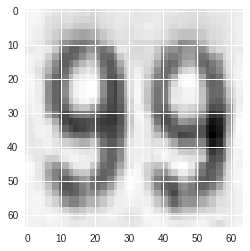

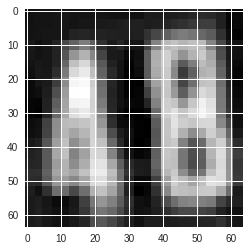

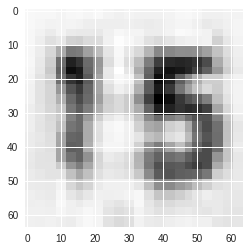

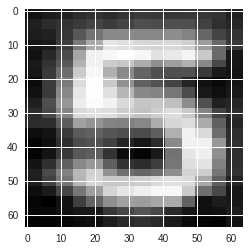

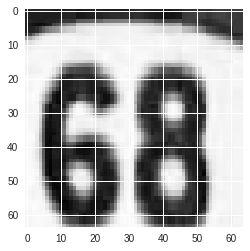

In [65]:
# Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    plt.figure()
    plt.imshow(test_dataset[i])
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Source: https://sajalsharma.com/portfolio/digit_sequence_recognition